## Import required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import re
from bs4 import BeautifulSoup
from datasets import Dataset
import torch

## Load the dataset

In [2]:
df = pd.read_csv('/content/email.csv')

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Preprocessing and cleaning

In [4]:
## Check for duplicates
df.duplicated().sum()

np.int64(415)

In [5]:
## Drop duplicates
df.drop_duplicates(subset=['Message'], inplace=True)

In [6]:
# Check for null values
df.isnull().sum()

,0
Category,0
Message,0


In [7]:
# Shape of the DataFrame
df.shape

(5158, 2)

In [8]:
# Encode lables
encode = {'ham': 0, 'spam': 1}
df['Category'] = df['Category'].map(encode)


In [9]:
# Check the count of unique label
print(df['Category'].value_counts())

Category
0.0    4516
1.0     641
Name: count, dtype: int64


In [10]:
# Drop null values of Category column
df.dropna(subset=['Category'], inplace=True)

In [11]:
# Function for data cleaning
def clean_email(text):

    # Convert to string safely
    text = str(text)
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Replace URLs
    text = re.sub(r"http\S+|www\.\S+", " URL ", text)
    # Replace email addresses
    text = re.sub(r"\S+@\S+", " EMAIL ", text)
    # Replace phone numbers
    text = re.sub(r"\b\d{10}\b", " PHONE ", text)
    # Remove special characters that add noise
    text = re.sub(r"[^A-Za-z0-9!?.,;:()'\"]+", " ", text)
    # Normalize spaces
    text = " ".join(text.split())

    return text

In [12]:
# Apply the data cleaning function
df['Message'] = df['Message'].apply(clean_email)

## Train Test split

In [13]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.shape, test_df.shape

((4125, 2), (1032, 2))

### Convert the Category column from Float to int

In [14]:
train_df["Category"] = train_df["Category"].astype("int64")
test_df["Category"] = test_df["Category"].astype("int64")

In [15]:
# Convert to HuggingFace Transform
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

print(train_ds)
print(test_ds)

Dataset({
    features: ['Category', 'Message', '__index_level_0__'],
    num_rows: 4125
})
Dataset({
    features: ['Category', 'Message', '__index_level_0__'],
    num_rows: 1032
})


In [30]:
# Import transformer libraries
from transformers import RobertaTokenizer

In [17]:
# Load tokenizer
model_name="roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [18]:
# Define tokenization function
def tokenize_function(batch):
    tokens = tokenizer(
        batch["Message"],
        padding="max_length",
        truncation=True,
        max_length=256
    )
    tokens["labels"] = batch["Category"]
    return tokens
# Apply tokenize function to train and test dataset
train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

# Set format for pytroch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/4125 [00:00<?, ? examples/s]

Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

In [19]:
# Sample data
train_ds[0]

{'input_ids': tensor([    0, 40084, 14429,   267, 27315,     6, 34154,   119,     6, 29886,
             6,     7,  1193, 15577,   734,  8432,    10,   319,     9,  1421,
           141,     7,   224,   734,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

## Fine Tunning

In [20]:
from transformers import RobertaForSequenceClassification,
from transformers import TrainingArguments, Trainer

# Load the model
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

# Definie training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True
)

# Define metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaludation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Intialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train model
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: supratimsaha-ds (supratimsaha-ds-amz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.041400,0.062464,0.990310,0.990152,0.990417,0.990310
2,0.025800,0.023325,0.995155,0.995177,0.995235,0.995155
3,0.019500,0.014728,0.996124,0.996136,0.996164,0.996124


TrainOutput(global_step=774, training_loss=0.05187769551419723, metrics={'train_runtime': 746.0232, 'train_samples_per_second': 16.588, 'train_steps_per_second': 1.038, 'total_flos': 1627999655040000.0, 'train_loss': 0.05187769551419723, 'epoch': 3.0})

## Evaluate

In [22]:
results = trainer.evaluate()
print("Accuracy: ", results["eval_accuracy"])

Accuracy:  0.9961240310077519


Classification Report: 
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       896
        spam       0.98      0.99      0.99       136

    accuracy                           1.00      1032
   macro avg       0.99      0.99      0.99      1032
weighted avg       1.00      1.00      1.00      1032

Confusion Matrix: 


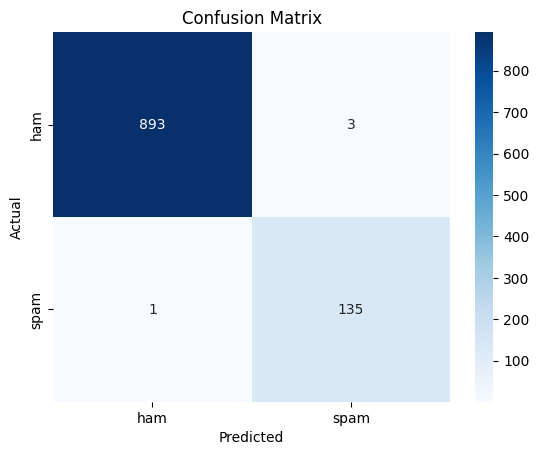

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation dataset
predictions = trainer.predict(test_ds)

# Get predicted labels and true labels
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

## Print Classification report:
print("Classification Report: ")
print(classification_report(y_true, y_pred, target_names=['ham', 'spam']))

## Print Confusion Matrix:
print("Confusion Matrix: ")
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['ham', 'spam'],
    yticklabels=['ham', 'spam']
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Saving Fine Tuned mPdel

In [25]:
from google.colab import drive
import pickle

## Save the model and tokenizer
model_save_path = "/content/drive/MyDrive/saved_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('/content/drive/MyDrive/saved_model/tokenizer_config.json',
 '/content/drive/MyDrive/saved_model/special_tokens_map.json',
 '/content/drive/MyDrive/saved_model/vocab.json',
 '/content/drive/MyDrive/saved_model/merges.txt',
 '/content/drive/MyDrive/saved_model/added_tokens.json')

In [26]:
import torch
# Load the fine-tuned model and tokenizer
model_save_path = "/content/drive/MyDrive/saved_model"
tokenizer = RobertaTokenizer.from_pretrained(model_save_path)
model = RobertaForSequenceClassification.from_pretrained(model_save_path)

# Function for prediction
def predict(text):
    encoded = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)

    # Forward pass to get predictions
    with torch.no_grad():
        output = model(**encoded)
    logits = output.logits
    pred = torch.argmax(logits, dim=1).item()
    return "SPAM" if pred == 1 else "HAM"

In [29]:
## Example predictions
example_texts = [
    "You won $1000!!! Click here",
    "Did you hear about the new ""Affair Barbie""? It comes with all of Jim's stuff!",
    "HEY DUDE. You are LUCKY winner of Doodle Content in Nevada"
]

for text in example_texts:
    prediction = predict(text)
    print(f"Email:{text} \nPrediction: {prediction}\n")

Email:You won $1000!!! Click here 
Prediction: SPAM

Email:Did you hear about the new Affair Barbie? It comes with all of Jim's stuff! 
Prediction: HAM

Email:HEY DUDE. You are LUCKY winner of Doodle Content in Nevada 
Prediction: SPAM

